## CPU和GPU 
#### 一般的GPU电脑
- Intel i7 7th, 0.15 TFLOPS
- DDR4 32G
- Nvidia Titan x 12TFLOPS 16G

#### 提升CPU利用率1
- 在计算a+b前，需要准备数据
    - 主内存->L3->L2->L1->寄存器
        - L1访问延迟：0.5ns
        - L2访问延迟：7ns(14xL1)
        - 主内存访问延迟:100ns(200xL1)
- 提升空间和时间的内存本地性
    - 时间：重用数据使得保存他们在缓存里
    - 空间：按序读写数据使得可以预读取
    
#### 样例分析
- 如果一个矩阵按行存储，访问一行会比访问一列块
    - CPU一次读取64字节（缓存线）
    - CPU会聪明提前读取下一个（缓存线）
    
#### 提升CPU利用率II
- 高端CPU有几十个核
    - 如EC P3.16Xlarge:2 intel Xeon CPUs 32物理核
- 并行来利用所有核
    - 超线程不一定提升性能，因为他们共享寄存器，对于计算密集型可能没用
    
#### 样例分析
- 左边比右边慢(python)
```
 for i in range(len(a)):               c = a+b
    c[i] = a[i] + b[i]
 ```   
   - 左边调用n次函数，每次调用有开销
   - 右边很容易并行（如下c++实现）
```
# prama omp for
for (i=0; i<s.size(); i++){
   c[i] = a[i] + b[i] 
}
```

#### CPU VS GPU
一般/高端
- 核心： 6/64       2k/4k
- TFLOPS：0.2/1      10/100
- 内存大小 32GB/1TB   16GB/32GB
- 内存带宽: 30GB/s /  100GB/s 400GB/s / 1TB/s
- 控制流：  强         弱
- 核心通过增加核的个数和带宽来提升运算，每个核可以做运算，量大，即使有的cpu运算可以但是带宽小，拖瓶颈

#### 提升GPU利用率
- 并行
    - 使用数千个线程，1k维度向量+好点，小模型不是很快
- 内存本地性
    - 缓存更小，架构更简单 
- 少用控制语句
    - 支持有限
    - 同步开销大
    
#### CPU/GPU带宽
- 不要频繁在CPU和GPU间传数据，带宽限制同步开销，尽量一次传，少传点，经常代码不规范传回来cpu
- 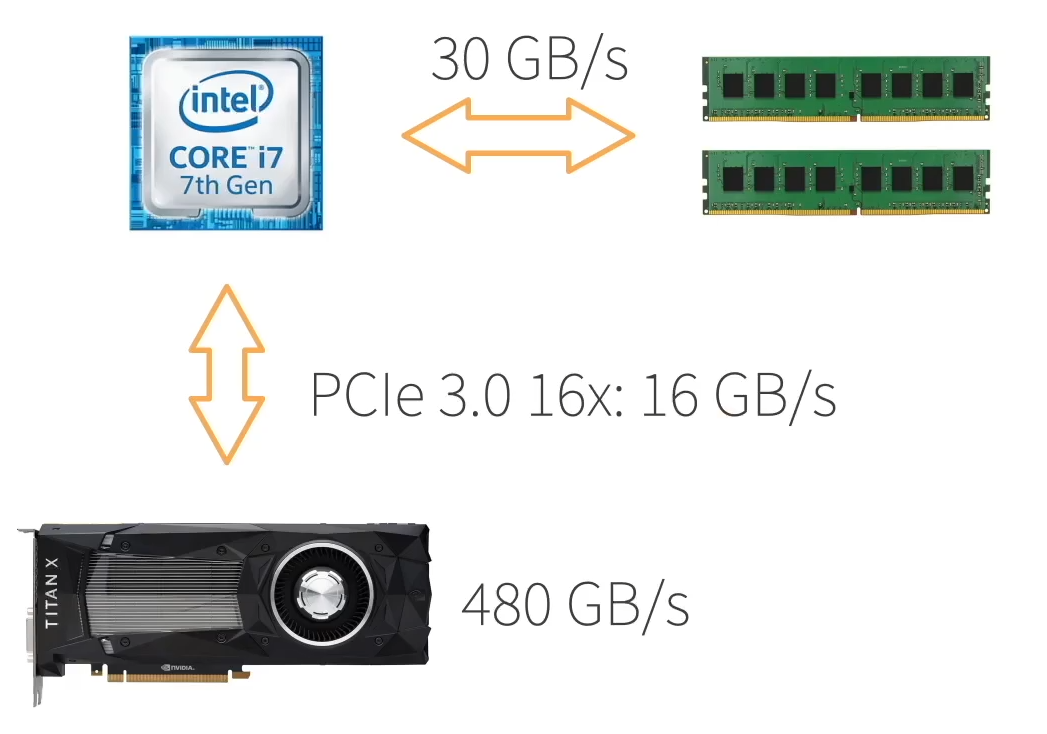

#### 更多CPUs和GPUs
- CPU: AMD ARM
- GPU: AMD INTEL ARM Qualcomm

#### CPU/GPU高性能计算编程
- CPU: c++或者任何高性能语言(fortran等)
    - 编译器成熟
- GPU
    - Nvidia上用CUDA
        - 编译器和驱动成熟
    - 其他用OpenCL
        - 质量取决硬件厂商
        
#### 总结
- CPU：可以处理通用计算，性能优化考虑数据读写效率和多线程
- GPU：使用更多的小核和更好的内存带宽，适合大规模并行的计算任务

## QA

#### 如果要提高泛化性，可能增加数据？调参的意思是不是最大了？
- 增加数据很可能是提高泛化性的最简单、有效的办法，不是差不多的数据，数据质量很重要，少量高质量数据比高质量有用，但是几千上w倍的低质量可能比少量高质量要好；
- 不要过度调参，很可能只拟合本数据集

#### 为什么AlexNet比Resnet参数量大？计算还快些？
- Resnet18好像18M，AlexNet 300M好像，ResNetxx简记就是xxM，AlexNet后面有大全连接，计算快，但是卷积层虽然参数少、但是网络深，计算量反而大，慢
- 深度学习中模型大小和计算复杂度不能等同，除非网络结构一样

#### resnet跟gbdt很香？
- 都有残差的概念，但是模型本质不一样

#### 写法w -= lr*w.grad跟w = w-lr*w.grad区别？都在torch.nograd下执行，后面为什么会梯度变成false
- 第二种写法，相当于新建了个tensor(w - lr*w.grad)，然后把他给新的w，这个w实在no grad情况下，所有肯定不会有梯度

#### 训练集aac不断增加，但是验证集的准确率不断震荡，是过拟合嘛？
- 大概率是过拟合，那个叶子数据集很简单，很容易过拟合

#### llc是显存还是缓存？llc是l1 l2 l3?
- llc: last level cache,看你有几个
- 瓶颈在于llc跟内存的交换

#### 按行存储要怎么改代码？
- 这个非常讲究，pytorch跟mxnet都是如果4d的话，channel放在第二个维度，第一个是batch size；tf放在最后，取决于dl框架理念，按照框架的来即可，后面还会自动切分 

#### c++有omp，python 有multiprocessing还是不行吗？
- python那个是进程，不行的，粒度大了，可以试试numba

#### 计算时把for loop运算尽量向量化？
- 尽量不要for loop，尽量矩阵化，tensor化
- 实在要for loop用cpp写，或者用low level python写

#### 可视化时，常需要把数据在cpu和GPU间切换，如何保证不频繁呢？
- 频繁是相对的，比如你最后的打印，log都没事的，只要不要1次运算就搬一次，不要1s搬个上G的数据，这种都是没问题的
- 一般可视化没问题的
- 大部分情况框架不会悄悄挪到cpu运算再挪回来，而且默认都是不同device运算会报错，看代码不报错不手动copy基本没啥问题

#### go适合做高性能计算嘛？
- go适合分布式系统，但是是更多关注网页host、视频等分布式文件等，而不是hpc（high performance computing）

#### rust跟fortran怎么样呢？
- rust是安全点，fortran现在也很少用了，以前主要编译器好，做高性能计算多，但是现在cpp不弱了

#### 如何复现论文？
- 80%论文无法复现
- 一般只有作者写的很细（关键细节），然后看懂每一句话，每一句
- 很多时候，看别人复现的，作者代码，反复看看，琢磨细节，很锻炼的事情，建议做

#### pytorch dataloader有哪些常用加速办法——开多进程

#### 测量可以用dl吗？做的不多吗？
- 可以添加硬件，景深，能用硬件解决就用硬件解决

#### 框架调用cppapi和pyapi差距多大？
- c调用cpp差别不大， 但是调用python会有大损耗，numpy用的cpython，效果还行，pytorch直接python也还行（好像cpython？），python其他库开销不小
- python 有全局锁，经常会调来调去有开销

#### yolo出了darknet还有什么框架吗？
- 很少用darknet，也不怎么维护
- gluon cv,pytorch，tf都有的

#### resnet只能图像领域吗？文本可以吗？
- 对的，文本不行的，但是后面会说卷积做文本

#### TF/MXNET的底层都是cpp，为什么infer 还是cpp调用快呢？
- 上层python调用cpp会有点损失，主要还是infer的时候不想装python环境

#### xvier和BN可以一起用吗？——可以

#### 打比赛发现很多都是模型继承，没什么好处？
- 打比赛可以学习下，但是别指望学太多，一般学的不多

#### 是不是spark比mapreduce多很多？——对

# TPU和其他
#### DSP：数字信号处理——牛逼的高通（qualcomm）
- 为数字信号处理算法设计：点积、卷积、FFT
- 低功耗、高性能
    - 比移动GPU快5x，功耗更低
- VLIW: Very long instruction word
    - 一条指令计算上百次乘累加（如果一次计算没有上百次就浪费了）
- 编程和调试困难
- 编译器质量良莠不齐

#### 可编程阵列（FPGA）
- 有大量的可以编程逻辑单元和可配置的连接
- 可以配置成计算复杂函数
    - 编程语言：VHDL, Verilog
- 通常比通用硬件更高效
- 一次“编译”需要数小时
    - FPGA取决班子大小，因为是改变物理上的逻辑单元，所以编译很慢
    - 大的班子可能编译几天，高端的FPGA可能比高性能的GPU还有效

#### AI ASIC
- 深度学习的热门领域
    - 大公司都在造自己的芯片（Intel， Qualcomm，Google， Amazon， Facebook）
- Google TPU是标志性芯片
    - 能够媲美Nvidia GPU性能 
    - 在google大量部署
    - 核心是systolic array
- 硬件越专用，越方便造出来
- 流片很贵（一次几百上kw美金？），一般先做cpu上模拟，然后fpga上模拟，都没问题了，才去流片
- 一做可能就2-3年，几亿美金
    
####  Systolic Array
- 计算单元（PE）阵列
- 特别适合做矩阵乘法
- 设计和制造相对简单
- 对于一般的矩阵乘法，通过切开和填充来匹配SA大小
- 批量输入来降低延迟
- 通常有其他硬件单元来处理别的NN操作子，例如激活层
- 但是如果NN架构突然不火了，架构可能不适用了
 
 
#### 总结
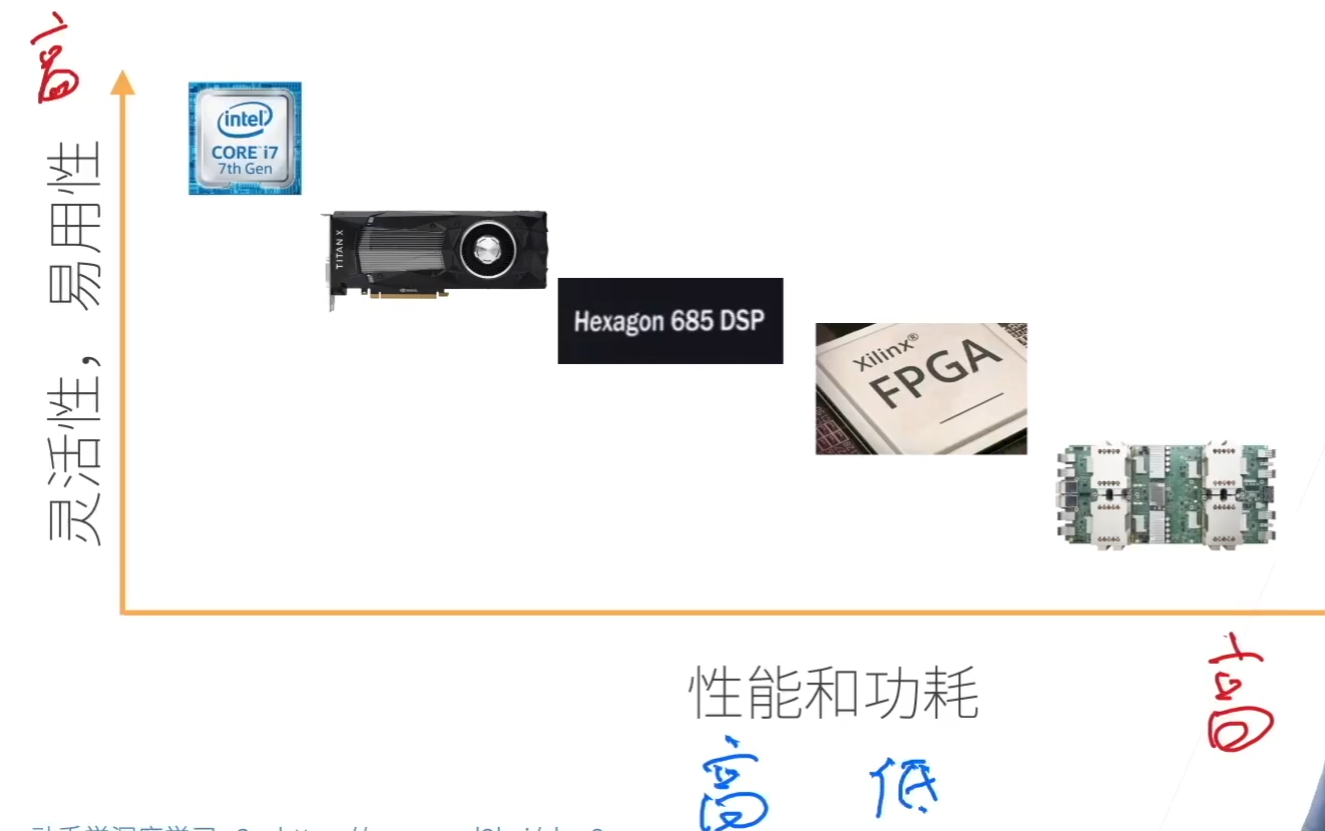

# QA
#### FPGA 怎么学呢？
- 想清楚要干嘛，网上东西那么多，干嘛要学呢，有的FPGA可以用c/cpp开发

#### 性能对比？FPGA一般来验证asic的设计？
- 一般是在同样工艺下，同样大小下对比，越专用越强
- FPGA有很多领域，如华为的路由器很多都是FPGA做的
- 数据中心很多用FPGA做的，如微软xx网页就是GPU做的

#### pytorch有tpu接口吗？
- 有的，但是建议tf
- jax也有tpu，公用tf后端

#### 功耗？
- GPU 300W TPU400w差别不大，服务端（30%），云上的东西不考虑功耗，可能空调才是大头，电费不是大头，硬件才是大头，性能才是问题
- 只有离用户近的才考虑功耗（需要用电池）

#### 未来3-5年应用会发生大变化吗？ai asic会被淘汰吗？
- 这个很复杂，硬件跟算法是鸡生蛋生鸡的问题

#### Risc V做硬件怎么样呢？
- 一般很便宜，无授权费，所以用在低廉场景（只能家具之类的）

#### TPU在边缘端有实现吗？
- 有的，edge-tpu,可以usb插在树莓派上

#### 带NPU的芯片如nxp，rockchip 高通怎么样呢？
- 其实很多都是DSP，如rockchip，一般NPU都是打包卖，单卖卖不动

#### NPU的 2t ops能顺畅跑 30fps deeplab v3+吗？
- 不好说，NPU你跑个10%都不一定了，虚标
- Nvidia的标的一般都差不多真的
